In this notebook, we are trying to understand which factors may affect the student's performance. In order to discover correlations between factors, we will classify the scores into several unique groups.

Let's pay attention that dataset consists of five independent variables which are:

gender: sex of students (male, female)

race/ethnicity: race of students (A-E groups)

parental level of education: parents' final education

lunch: having lunch before test (standard, free/reduced)

test preparation course: having completed the preparation course before the test (none,completed)

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  

Let's have a look at the dataset.

In [30]:
score_df = pd.read_csv('StudentsPerformance.csv')
score_df.sample(7)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
375,male,group E,associate's degree,free/reduced,none,46,43,41
143,male,group A,high school,standard,none,57,43,47
751,male,group E,some college,standard,none,68,72,65
498,female,group B,some high school,standard,none,66,69,68
642,female,group B,some high school,free/reduced,none,72,81,79
623,male,group A,some college,standard,completed,100,96,86
282,female,group D,bachelor's degree,free/reduced,none,73,79,84


We can see that some columns' names are too long. Let's abbreviate them.

In [31]:
score_df.rename(
    columns={
        'race/ethnicity': 'race',
        'parental level of education': 'parent_education',
        'test preparation course': 'prep_course',
        'math score': 'math',
        'reading score': 'reading',
        'writing score': 'writing'
    },
    inplace=True
)

score_df.sample(7)    

,gender,race,parent_education,lunch,prep_course,math,reading,writing
505,female,group B,some high school,standard,none,82,82,80
39,male,group B,associate's degree,free/reduced,none,57,56,57
438,male,group C,high school,standard,none,70,56,51
365,male,group A,bachelor's degree,free/reduced,completed,49,58,60
307,male,group C,some high school,standard,none,51,52,44
109,female,group B,some high school,standard,none,70,64,72
534,male,group B,high school,standard,completed,73,69,68


It looks way better than before. Although we shortened columns' names, we are still able to recognize each meaning easily. We should check the data types.

In [32]:
score_df.dtypes

gender              object
race                object
parent_education    object
lunch               object
prep_course         object
math                 int64
reading              int64
writing              int64
dtype: object

We can see that most of the columns have a type of 'object'. This data type is not desirable when it comes to our analysis. It's better to deal with numerical representations of these features. Let's encode them.

In [33]:
labelencoder = LabelEncoder()
train_df = score_df.copy()
train_df['parent_education'] = labelencoder.fit_transform(train_df['parent_education'])
train_df['lunch'] = labelencoder.fit_transform(train_df['lunch'])
train_df['prep_course'] = labelencoder.fit_transform(train_df['prep_course'])

train_df.sample(7)

,gender,race,parent_education,lunch,prep_course,math,reading,writing
549,male,group C,3,1,1,79,72,69
531,female,group C,5,1,1,47,54,53
321,female,group E,2,1,1,75,86,79
421,female,group D,2,1,0,57,58,64
298,male,group C,2,0,0,40,46,50
968,female,group E,0,1,1,68,76,67
691,female,group E,0,0,1,73,76,78


Nice! We have our 'parent_education', 'lunch' and 'prep_course' features encoded.

Let's classify them using a clustering algorithm -KMeans algorithm. We are interested in all dataframe columns, excluding gender and race.

💡TIP💡: Inertia tells how far away the points within a cluster are (sum of squared distances).

c:\Users\przem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


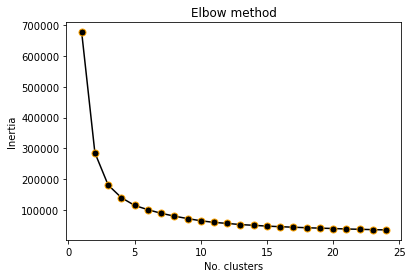

In [34]:
inertias = list()
for i in range(1,25):
    kmeans = KMeans(init = "k-means++", n_clusters = i, n_init = 30)
    kmeans.fit_transform(train_df.iloc[:, 2:]) # We are interested in all columns, excluding gender and race
    inertias.append(kmeans.inertia_) 

plt.plot(range(1,25), inertias, marker='o', color = 'black', mec = 'orange', ms = 7)
plt.title('Elbow method')
plt.xlabel('No. clusters')
plt.ylabel('Inertia')
plt.show()

Great! With this beautiful plot, we need to determine the elbow point. It appears to be 8.

💡TIP💡 The elbow point is where the curve starts to flatten.

In [35]:
kmeans = KMeans(init = "k-means++", n_init = 8)
kmeans.fit_transform(train_df.iloc[:, 2:])
kmeans_label = kmeans.labels_
score_df["cluster_group"] = kmeans_label
score_df.head(10)

,gender,race,parent_education,lunch,prep_course,math,reading,writing,cluster_group
0,female,group B,bachelor's degree,standard,none,72,72,74,0
1,female,group C,some college,standard,completed,69,90,88,7
2,female,group B,master's degree,standard,none,90,95,93,5
3,male,group A,associate's degree,free/reduced,none,47,57,44,4
4,male,group C,some college,standard,none,76,78,75,2
5,female,group B,associate's degree,standard,none,71,83,78,2
6,female,group B,some college,standard,completed,88,95,92,5
7,male,group B,some college,free/reduced,none,40,43,39,1
8,male,group D,high school,free/reduced,completed,64,64,67,6
9,female,group B,high school,free/reduced,none,38,60,50,4


Alright! We have eight clusters, so check performance for each of them.

In [36]:
grouped_df = score_df.groupby("cluster_group")[score_df.columns[5:8]].mean()
grouped_df

,math,reading,writing
cluster_group,,,
0,74.530303,69.871212,68.121212
1,32.358974,36.589744,34.025641
2,68.000000,77.933333,77.666667
3,63.088000,58.712000,56.840000
4,48.670807,52.416149,50.229814
5,89.642857,93.345238,93.357143
6,58.012739,67.528662,67.745223
7,81.769737,82.947368,81.677632


Let's visualize it.

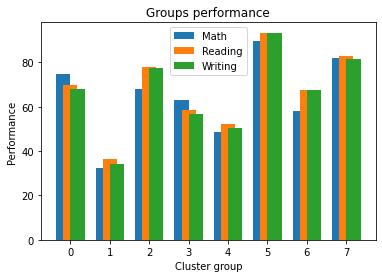

In [37]:
idx = np.arange(8)
width = 0.36

fig, ax = plt.subplots()
math_bar = ax.bar(idx - width/2, grouped_df['math'], width, label = 'Math')
reading_bar = ax.bar(idx, grouped_df['reading'], width, label = 'Reading')
reading_bar = ax.bar(idx  + width/2, grouped_df['writing'], width, label = 'Writing')

ax.set_xlabel('Cluster group')
ax.set_ylabel('Performance')
ax.set_title('Groups performance')
ax.legend()
plt.show()